# Projet Camembert
### Objectifs
- Etape 1 : Recomposer sur 2014 la répartition hebdo des paniers sur un maximum de centres
- Etape 2 : Mettre en place un score pour noter l'équilibre alimentaire sur une semaine
- Etape 3 : Viz -> Sélection du centre > Accès aux semaines via un carré coloré reprenant le score > accès au camembert de la semaine

### Vous avez dit équililibre alimentaire ?

Voici la répartition du panier alimentaire équilibré tel que défini par la Croix-Rouge
<img src="panier.png">

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from ggplot import *

## Correspondance des catégories au sein de la table itmcorres

Catégories de produit défines dans la base :

In [2]:
query = """SELECT
cat2,
COUNT(cat2) as nb_item
FROM [stojou.itmcorres]
GROUP BY cat2"""

cat = pd.read_gbq(query,project_id='croix-rouge-92715')

Waiting for job to complete...


In [3]:
mapping_cat = {
    "FL": "Fruits Legumes",
    "PL2": "Produits laitiers",
    "LPL": "Produits laitiers",
    "VOP": "Viandes, oeuf, poisson",
    "PFM": "Viandes, oeuf, poisson", #PFM = Poissons, Fruits de mer ?
    "MTG": "Matieres grasses ajoutees",
    "FEC": "Feculents",
    "PGS": "Produits gras, sucres ou sales",
    "EAU": "Hygiene, eau",
    "HYG": "Hygiene, eau",
    "SUC": "Autres",
    "CET": "Autres",
    "ACN": "Autres",
    "CHE": "Autres",
    "CSN": "Autres",
    "DGR": "Autres",
    "CAP": "Autres",
    "BON": "Autres",
    "BUR": "Autres",
    "PDP": "Autres",
    "ACL": "Autres",
    "PDV": "Autres",
    "ETL": "Autres",
    "CFT": "Autres",
    "ACH": "Autres",
    "CDM": "Autres",
    "ETM": "Autres",
    "MAT": "Autres"    
}

In [4]:
cat['new_catego'] = cat["cat2"].map(mapping_cat)
cat

,cat2,nb_item,new_catego
0,FL,13365,Fruits Legumes
1,VOP,17841,"Viandes, oeuf, poisson"
2,PGS,40183,"Produits gras, sucres ou sales"
3,LPL,10509,Produits laitiers
4,FEC,9760,Feculents
5,EAU,829,"Hygiene, eau"
6,MTG,3537,Matieres grasses ajoutees
7,HYG,3374,"Hygiene, eau"
8,ETM,1493,Autres
9,CDM,2958,Autres


## Au travail sur les données des produits fournis aux bénéficiaires

Query ci-dessous :
- Le numéro de pièce (VCRNUM_0) commence par "DIS" pour Distribution
- l'année est 2014
- Pour le 91,92,93,94,95 (et déjà la query prend un peu de temps, patience ! ;) )
- Sur les catégories de produits mappées (+ de 90% des pdts distribués)


In [5]:
query = """SELECT
  date,
  cat2,
  dpt_nb,
  OWNER_0 Centre,
  Qty,
  VCRNUM_0 num_piece,
  Invoice.BPR beneficiaire_id,
  Invoice.YNBR taille_foyer
FROM (
Select 
  TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00')) date,
  MONTH(TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00'))) month,
  YEAR(TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00'))) year,
  OWNER_0,
  ITMREF_0,
  CAST(QTYSTU_0 AS INTEGER) Qty,
  corres.cat2 AS cat2,
  VCRNUM_0
FROM [stojou.stojou] input
  JOIN (
    SELECT
      itemref,cat2
    FROM
      [stojou.itmcorres]) corres
    ON
      input.ITMREF_0 = corres.itemref
    WHERE corres.cat2 IN ('FL','FEC','VOP','LPL','PGS','PFM','PL2','MTG')
    
    ) AS joined
  
  JOIN (
    SELECT
      CD_U2A, CD_DEPT dpt_nb
    FROM
      [stojou.dim_u2a_ville]) dpt
  ON
    joined.OWNER_0 = dpt.CD_U2A
  LEFT JOIN (
    SELECT
      NUM,
      BPR,
      YNBR
    FROM
     [stojou.SINVOICE_M]) Invoice
  ON Invoice.NUM = joined.VCRNUM_0
    
WHERE
date >= TIMESTAMP('2014-01-01  00:00:00') AND
dpt_nb in ('93','92','91','94','95') AND
SUBSTRING(VCRNUM_0,0,3) == "DIS"
"""

paniers = pd.read_gbq(query,project_id='croix-rouge-92715')

Waiting for job to complete...


In [6]:
paniers.head(10)

,date,cat2,dpt_nb,Centre,Qty,num_piece,beneficiaire_id,taille_foyer
0,2014-01-07,PGS,92,U9201,-1,DIS140107006328,120092070,1
1,2014-01-07,VOP,92,U9201,-1,DIS140107006328,120092070,1
2,2014-01-07,FL,92,U9201,-1,DIS140107006328,120092070,1
3,2014-01-07,PGS,92,U9201,-1,DIS140107006328,120092070,1
4,2014-01-07,VOP,92,U9201,-1,DIS140107006328,120092070,1
5,2014-01-07,LPL,92,U9201,-8,DIS140107006328,120092070,1
6,2014-01-07,FL,92,U9201,1,DIS140107006328,120092070,1
7,2014-01-07,PGS,92,U9201,-1,DIS140107006328,120092070,1
8,2014-01-07,FL,91,U9101,-1,DIS140107003938,120047364,1
9,2014-01-07,FL,91,U9101,-1,DIS140107003938,120047364,1


In [7]:
paniers = paniers.set_index(paniers['date'])

In [8]:
paniers['catego'] = paniers['cat2'].map(mapping_cat)

### Nettoyage : unusual quantities et centres inactifs
Après quelques essais, j'ai retenu comme "unusual quantity" le seuil de 20 produits identiques distribués à la même personnes.

In [9]:
paniers['taille_foyer'] = paniers['taille_foyer'].astype('int64')
unusual_qty = paniers[(paniers['Qty'] < -20) & (paniers['taille_foyer'] < 2)]
beneficiary_excluded = unusual_qty['Qty'].groupby(unusual_qty['beneficiaire_id']).sum().index

On exclut les bénéficiaires pour qui les quantités distribuées sont suspectes

In [10]:
paniers = paniers[~paniers['beneficiaire_id'].isin(beneficiary_excluded)]

Les Quantités positives semblent correspondre à des annulations en caisse (voir exemple ci-dessous).

On les sommera donc au moment de déterminer notre panier moyen.

In [11]:
paniers[paniers['num_piece'] == 'DIS140904005596']

,date,cat2,dpt_nb,Centre,Qty,num_piece,beneficiaire_id,taille_foyer,catego
date,,,,,,,,,
2014-09-04,2014-09-04,LPL,93,U9308,-2,DIS140904005596,140170353,4,Produits laitiers
2014-09-04,2014-09-04,FL,93,U9308,-2,DIS140904005596,140170353,4,Fruits Legumes
2014-09-04,2014-09-04,PGS,93,U9308,-1,DIS140904005596,140170353,4,"Produits gras, sucres ou sales"
2014-09-04,2014-09-04,FEC,93,U9308,-1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,FEC,93,U9308,-1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,PGS,93,U9308,-1,DIS140904005596,140170353,4,"Produits gras, sucres ou sales"
2014-09-04,2014-09-04,FEC,93,U9308,1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,FL,93,U9308,-1,DIS140904005596,140170353,4,Fruits Legumes
2014-09-04,2014-09-04,FL,93,U9308,-1,DIS140904005596,140170353,4,Fruits Legumes


### Nombre de semaines où on a de la data / centre

In [12]:
panier_serie2 = paniers['Qty'].groupby([paniers['date'], paniers['Centre']]).sum()
grouped2 = panier_serie2.unstack()
by_week2 = grouped2.resample('W',how='sum')

/usr/local/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [13]:
active_weeks = pd.DataFrame()
active_weeks['nb_weeks'] = 49 - by_week2.isnull().sum()
active_weeks['total_qty'] = by_week2.sum()
active_weeks.sort_values('nb_weeks', ascending=False)

,nb_weeks,total_qty
Centre,,
U9103,42,-9118
U9102,42,-71618
U9101,41,-74176
U9201,41,-20391
U9208,41,-58366
U9211,41,-12191
U9504,39,-45466
U9203,39,-11951
U9306,38,-14711


## Détermination du panier moyen hebdo par centre et par semaine

In [14]:
new_paniers = paniers.copy()
centres_with_data = active_weeks[active_weeks['nb_weeks'] > 34].index
new_paniers = new_paniers[new_paniers['Centre'].isin(centres_with_data)]

In [15]:
panier_serie = new_paniers['Qty'].groupby([new_paniers['date'], new_paniers['catego'],new_paniers['Centre']]).sum()

In [16]:
grouped = panier_serie.unstack().unstack()

In [17]:
by_week = grouped.resample('W',how='sum').fillna(0)

In [18]:
Centres = by_week.columns.get_level_values(0)

In [19]:
by_week_percent = by_week.copy()
for Centre in Centres:
    tmp = by_week[Centre]
    rowSum = tmp.sum(1)
    by_week_percent[Centre] = tmp.divide(rowSum,axis=0) * 100

In [20]:
by_week_percent

Centre          U9101                                           \
catego      Feculents Fruits Legumes Matieres grasses ajoutees   
date                                                             
2014-01-05  11.723447      20.240481                 11.523046   
2014-01-12   9.010989      20.659341                  0.164835   
2014-01-19  11.884058      23.710145                  0.115942   
2014-01-26  10.233222      25.130890                  0.666349   
2014-02-02  14.107884      17.750115                  0.092208   
2014-02-09   9.352837      19.326241                  9.086879   
2014-02-16   8.090615      15.048544                  0.606796   
2014-02-23   8.357441      31.822565                  0.064288   
2014-03-02  10.212474      24.845785                  0.137080   
2014-03-09  10.078157      19.909502                  6.869601   
2014-03-16  12.362159      25.159605                  0.667441   
2014-03-23  15.805947      19.679186                 -0.000000   
2014-03-30  15.140264      17.409241                  0.288779   
2014-04-06  10.691824      15.055031                  7.389937   
2014-04-13  15.214564      13.740789                  0.866927   
2014-04-20  11.380880      18.209408                 -0.000000   
2014-04-27  13.218391      19.731801                  1.724138   
2014-05-04  20.836055      24.297845                  7.576747   
2014-05-11  15.303983      34.171908                  9.294200   
2014-05-18  12.714430      22.452069                  1.109990   
2014-05-25   9.893390      21.961620                  0.085288   
2014-06-01  10.299625      19.225968                  2.808989   
2014-06-08  11.846367      18.047200                  9.393799   
2014-06-15  12.827782       8.221120                  0.070872   
2014-06-22  10.531545      13.363140                 -0.000000   
2014-06-29  15.477214      13.886500                  0.902837   
2014-07-06        NaN            NaN                       NaN   
2014-07-13        NaN            NaN                       NaN   
2014-07-20        NaN            NaN                       NaN   
2014-07-27        NaN            NaN                       NaN   
2014-08-03        NaN            NaN                       NaN   
2014-08-10        NaN            NaN                       NaN   
2014-08-17        NaN            NaN                       NaN   
2014-08-24  15.236427      20.315236                  0.175131   
2014-08-31  11.828859      10.570470                  0.167785   
2014-09-07  15.390687      18.942384                 11.049724   
2014-09-14  13.020031      16.795069                  0.385208   
2014-09-21  16.267123      18.321918                  0.085616   
2014-09-28  15.047619      20.571429                  0.063492   
2014-10-05  21.801665      15.821347                  0.529902   
2014-10-12  16.837561      16.459795                  0.647598   
2014-10-19  26.451078      27.031509                  8.043118   
2014-10-26  21.972318      31.920415                  0.346021   
2014-11-02  16.666667      25.625000                  0.416667   
2014-11-09   8.755760      19.723502                  0.184332   
2014-11-16   9.720373      20.772304                  0.932091   
2014-11-23  27.015058      30.735164                  0.088574   
2014-11-30  10.406938      19.813209                 10.473649   
2014-12-07        NaN            NaN                       NaN   

Centre                                                       \
catego     Produits gras, sucres ou sales Produits laitiers   
date                                                          
2014-01-05                       9.919840         28.056112   
2014-01-12                      25.274725         22.197802   
2014-01-19                      15.478261         31.884058   
2014-01-26                      12.851023         29.366968   
2014-02-02                      14.522822         31.304749   
2014-02-09                      10.195035         25.753546   


## Juste pour le fun un petit exemple sur le premier centre

In [21]:
example = by_week_percent['U9101'][by_week_percent.index == by_week_percent.index[0]]

In [22]:
example

catego,Feculents,Fruits Legumes,Matieres grasses ajoutees,"Produits gras, sucres ou sales",Produits laitiers,"Viandes, oeuf, poisson"
date,,,,,,
2014-01-05,11.723447,20.240481,11.523046,9.91984,28.056112,18.537074


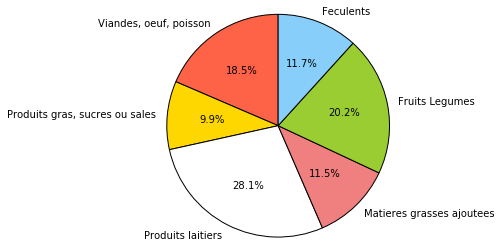

In [23]:
labels = example.columns[5],example.columns[3],example.columns[4],example.columns[2],example.columns[1],example.columns[0]
sizes = [  example.iloc[0][5],example.iloc[0][3],example.iloc[0][4],example.iloc[0][2],example.iloc[0][1],example.iloc[0][0]]
colors = ['tomato','gold', 'white','lightcoral','yellowgreen','lightskyblue']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()

## Proposition de calcul d'un score

En regardant le camembert ci-dessus, on se rend compte assez vite qu'un déséquilibre dans une catégorie de produit entraîne mécaniquement un déséquilibre dans une ou plusieurs autres.

Pour un centre et une semaine en particulier, pour chaque catégorie de produit on calcule l'écart à la répartition idéale et on garde le max de la valeur absolue comme écart.

Il s'agira ensuite fixer une échelle.

In [24]:
# Attention : j'ai utilisé une liste ici, pas très robuste, elle suit l'ordre des produits dans by_week_percent
desequilibrium = pd.DataFrame()
ideal = [25,33,2,2.5,25,12]
for Centre in Centres:
    desequilibrium[Centre] = np.subtract(by_week_percent[Centre], ideal).abs().max(1)

In [25]:
desequilibrium.describe()

,U9101,U9102,U9103,U9201,U9203,U9208,U9211,U9306,U9504
count,41.000000,42.000000,42.000000,41.000000,39.000000,41.000000,41.000000,38.000000,39.000000
mean,24.169142,22.108878,18.049411,32.862071,44.747003,27.165016,21.880555,31.568596,27.053025
std,8.934772,3.382545,3.797383,9.576566,7.515033,3.626150,4.053210,12.610074,7.786403
min,7.065988,13.062549,11.842105,16.884615,30.541667,20.872504,13.981775,13.130564,13.872618
25%,17.500000,20.531042,15.591481,25.680354,38.651951,24.192214,19.251412,20.467559,22.305907
50%,23.011006,21.748134,17.095741,33.633122,45.887097,26.845727,21.343416,31.514017,25.188919
75%,30.959255,25.018070,20.154777,35.474684,50.049846,29.829394,24.841772,36.720117,32.837662
max,41.506849,28.548387,31.125000,66.250000,57.235974,35.826087,30.509709,65.000000,47.500000


Voilà l'échelle que je propose :
- 10 : Excellent
- 17.5 : Ok
- 25 : Standard
- 32.5 : Mauvais
- 40 : Intolérable